<a href="https://colab.research.google.com/github/akiyoss-git/autumn_2020/blob/main/%D0%A1%D0%B5%D1%80%D0%B5%D0%B1%D1%80%D1%8F%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%923.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Серебрянский Александр Сергеевич 18-АС (18-ИВТ-1)
#3 Вариант

##Подготовка, Импорты

In [ ]:
!pip install -U keras-tuner
!pip install -U pygal

import pandas as pd
import numpy as np
import random
import pygal
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from keras.layers import Dropout
from keras import backend as K
from keras.regularizers import L1, L2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from keras import utils
from sklearn.preprocessing import MinMaxScaler


Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)
Requirement already up-to-date: pygal in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Подготовка данных

###Получение и вывод тренировочных данных

In [ ]:
train_path = '/content/drive/My Drive/labs/train.csv'
data = pd.read_csv(train_path)
data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Удаление столбика ID

In [ ]:
del data['ID']
data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


###Получение истинных значений и удаление стобца Y

In [ ]:
y_data = data.get('y')
x_data = data.drop('y' , axis=1)

###Выделение и удаление странных данных, у которых значение, отличное от нуля только в одной строке

In [ ]:
strange_data = []
for col in x_data:
    if len(x_data[col].unique()) == 1:
        strange_data.append(col)
x_data[strange_data].describe()
x_data.drop(strange_data, 1, inplace = True)

###Кодирование буквенных данных

In [ ]:
# list of categorical variables
word_vars = [var for var in x_data.columns if x_data[var].dtypes == 'O']
# все буквы и цифры шифруются, чтобы остались только числа
df = pd.DataFrame(x_data[word_vars])
x_data[word_vars] = df.apply(preprocessing.LabelEncoder().fit_transform)

print(x_data[word_vars])

mms = MinMaxScaler()
x_data[word_vars] = mms.fit_transform(x_data[word_vars])

      X0  X1  X2  X3  X4  X5  X6  X8
0     32  23  17   0   3  24   9  14
1     32  21  19   4   3  28  11  14
2     20  24  34   2   3  27   9  23
3     20  21  34   5   3  27  11   4
4     20  23  34   5   3  12   3  13
...   ..  ..  ..  ..  ..  ..  ..  ..
4204   8  20  16   2   3   0   3  16
4205  31  16  40   3   3   0   7   7
4206   8  23  38   0   3   0   6   4
4207   9  19  25   5   3   0  11  20
4208  46  19   3   2   3   0   6  22

[4209 rows x 8 columns]


###Разделение данных на тренировочные и тестовые

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=0, test_size = 0.2)

##Создание и обучение нейросети

###Создание нейросети

In [ ]:
model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))
print("[DEBUG-USER] nn created")

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
print("[DEBUG-USER] nn compiled")

model.summary()

[DEBUG-USER] nn created
[DEBUG-USER] nn compiled
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               46720     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 63,361
Trainable params: 63,361
Non-trainable params: 0
_________________________________________________________________


###Обучение нейросети

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=1, validation_split=0.2)
print(history)
history = history.history
print("[DEBUG-USER] nn finish")

Epoch 1/100
22/22 [==============================] - 0s 11ms/step - loss: 8760.6660 - mae: 92.5324 - val_loss: 5555.3433 - val_mae: 73.4979
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2155.8115 - mae: 39.1792 - val_loss: 538.8718 - val_mae: 19.4692
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 448.5766 - mae: 16.7008 - val_loss: 246.7857 - val_mae: 11.7031
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 247.6741 - mae: 12.0350 - val_loss: 172.5652 - val_mae: 10.0742
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 202.6749 - mae: 10.9329 - val_loss: 142.1328 - val_mae: 8.6118
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 176.0317 - mae: 10.1528 - val_loss: 123.3963 - val_mae: 7.9966
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 157.8128 - mae: 9.4238 - val_loss: 109.9196 - val_mae: 7.5257
Epoch 8/100
22/22 [======================

###Вывод графика

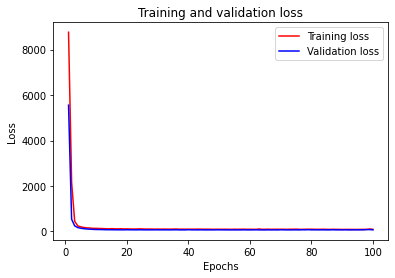

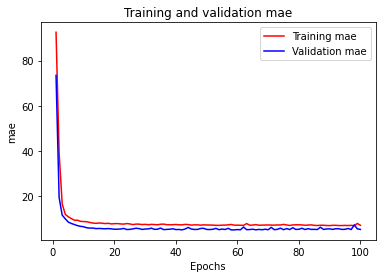

In [ ]:
def graphs(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()

    mae = history['mae']
    val_mae = history['val_mae']
    plt.plot(epochs, mae, 'r', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()



# рисуем все графики
graphs(history)

###Ошибки

In [ ]:
print("[INFO] RUNNING ON TEST DATA: \n")
# вычисляем ошибки и выводим их на экран
mse, mae = model.evaluate(x_test, y_test, verbose=0, batch_size=128)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

[INFO] Mean squared error is 103.0901870727539
[INFO] Mean absolute error is 5.73567533493042


##Keras Tuner

###Функция создания модели

In [ ]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=256,max_value=512,step=32),activation=activation_choice, input_shape=(x_train.shape[1], ), kernel_regularizer=L2(0.001)))
  model.add(Dropout(0.2))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=32//(i+1), max_value=128//(i+1),step=64//(i+1)),activation=activation_choice, kernel_regularizer=L2(0.001)))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
  return model

###Поиск с помощью Hyperband

In [ ]:

def find_best_NN(x_train_main, y_train_main):
  # создаю тюнер, который сможет подобрать оптимальную архитектуру модели
  tuner = Hyperband(build_model, objective="loss", max_epochs=20, hyperband_iterations=5)
  print("\n\n\n")
  # начинается автоматический подбор гиперпараметров
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=128, epochs=20, validation_split=0.3)
  # выбираем лучшую модель
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  # получаем лучшую модель
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = find_best_NN(x_train, y_train)






[INFO] start searching
Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3386.0222 - mae: 46.6810 - val_loss: 205.0837 - val_mae: 10.9556
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 174.2541 - mae: 9.9833 - val_loss: 122.6019 - val_mae: 8.1669
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 135.2922 - mae: 8.7442 - val_loss: 95.9633 - val_mae: 7.3967


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4172.3433 - mae: 55.1598 - val_loss: 216.3511 - val_mae: 11.1864
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 197.6243 - mae: 10.7351 - val_loss: 144.2193 - val_mae: 8.7326
Epoch 3/3
19/19 [==============================] - 0s 4ms/step - loss: 140.6691 - mae: 8.8753 - val_loss: 99.9320 - val_mae: 7.1050


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 6022.4351 - mae: 75.0934 - val_loss: 2128.0752 - val_mae: 44.3069
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 843.4069 - mae: 23.8277 - val_loss: 200.3922 - val_mae: 10.8546
Epoch 3/3
19/19 [==============================] - 0s 4ms/step - loss: 192.9771 - mae: 10.6755 - val_loss: 153.1981 - val_mae: 9.3492


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3579.2329 - mae: 47.5008 - val_loss: 196.7752 - val_mae: 10.8005
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 174.3743 - mae: 10.0213 - val_loss: 131.3805 - val_mae: 8.9070
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 133.1285 - mae: 8.6857 - val_loss: 92.2923 - val_mae: 6.7896


Epoch 1/3
19/19 [==============================] - 0s 13ms/step - loss: 3960.0947 - mae: 52.9221 - val_loss: 228.7524 - val_mae: 11.7236
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 196.0911 - mae: 10.6933 - val_loss: 141.5049 - val_mae: 8.7071
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 138.2803 - mae: 8.8167 - val_loss: 110.5998 - val_mae: 7.2055


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 6383.8872 - mae: 77.5078 - val_loss: 2086.4734 - val_mae: 43.8471
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 692.7084 - mae: 21.0357 - val_loss: 184.3139 - val_mae: 10.5504
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 176.0984 - mae: 10.1808 - val_loss: 142.2246 - val_mae: 9.1014


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 4326.1924 - mae: 59.3190 - val_loss: 349.1434 - val_mae: 14.6340
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 213.9916 - mae: 11.2311 - val_loss: 155.8234 - val_mae: 9.5750
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 148.2738 - mae: 9.1875 - val_loss: 113.4296 - val_mae: 7.8524


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 5128.0933 - mae: 64.5591 - val_loss: 278.4386 - val_mae: 12.8147
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 223.2536 - mae: 11.4873 - val_loss: 163.1435 - val_mae: 9.6061
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 160.1212 - mae: 9.5395 - val_loss: 180.4975 - val_mae: 9.9217


Epoch 1/3
19/19 [==============================] - 0s 13ms/step - loss: 3224.7446 - mae: 47.2888 - val_loss: 185.3084 - val_mae: 10.4669
Epoch 2/3
19/19 [==============================] - 0s 4ms/step - loss: 168.9175 - mae: 10.0373 - val_loss: 140.3448 - val_mae: 8.6711
Epoch 3/3
19/19 [==============================] - 0s 4ms/step - loss: 127.5277 - mae: 8.4243 - val_loss: 103.5102 - val_mae: 7.7381


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3835.3726 - mae: 51.5774 - val_loss: 215.8717 - val_mae: 11.3245
Epoch 2/3
19/19 [==============================] - 0s 4ms/step - loss: 191.6762 - mae: 10.5585 - val_loss: 132.2370 - val_mae: 8.6481
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 143.6361 - mae: 8.9854 - val_loss: 96.7605 - val_mae: 6.8156


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3085.5366 - mae: 46.3103 - val_loss: 177.5512 - val_mae: 10.1437
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 161.5305 - mae: 9.6569 - val_loss: 126.7461 - val_mae: 8.4140
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 125.1753 - mae: 8.3534 - val_loss: 100.4196 - val_mae: 7.5380


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3288.8010 - mae: 46.4719 - val_loss: 171.3984 - val_mae: 10.2180
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 156.0701 - mae: 9.5690 - val_loss: 118.9081 - val_mae: 8.0984
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 123.4317 - mae: 8.2609 - val_loss: 107.7571 - val_mae: 7.0150


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 6418.6699 - mae: 77.4245 - val_loss: 1351.3385 - val_mae: 34.3370
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 375.4623 - mae: 14.7982 - val_loss: 162.0337 - val_mae: 9.8431
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 151.6265 - mae: 9.3918 - val_loss: 135.0273 - val_mae: 9.1572
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 124.0238 - mae: 8.2729 - val_loss: 123.1106 - val_mae: 9.0468


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 3386.8835 - mae: 49.5281 - val_loss: 196.9070 - val_mae: 10.7280
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 169.9411 - mae: 10.0120 - val_loss: 133.3932 - val_mae: 8.8178
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 131.1847 - mae: 8.6023 - val_loss: 102.1489 - val_mae: 7.1210
Epoch 7/7
19/19 [==============================] - 0s 4ms/step - loss: 112.8380 - mae: 7.8043 - val_loss: 83.3138 - val_mae: 6.3340


Epoch 4/7
19/19 [==============================] - 0s 14ms/step - loss: 3268.2573 - mae: 48.4239 - val_loss: 195.5966 - val_mae: 10.7378
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 172.2510 - mae: 10.0040 - val_loss: 133.6785 - val_mae: 8.7556
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 127.2120 - mae: 8.4443 - val_loss: 99.9164 - val_mae: 7.3188
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 105.5440 - mae: 7.5525 - val_loss: 89.1976 - val_mae: 7.2410


Epoch 4/7
19/19 [==============================] - 0s 16ms/step - loss: 4185.7988 - mae: 54.1370 - val_loss: 213.8960 - val_mae: 11.3504
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 184.4367 - mae: 10.3365 - val_loss: 127.6170 - val_mae: 8.3758
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 142.9008 - mae: 8.8914 - val_loss: 95.1271 - val_mae: 7.0794
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 118.2798 - mae: 8.1624 - val_loss: 85.9912 - val_mae: 6.9564


Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 3003.8071 - mae: 45.1621 - val_loss: 176.7493 - val_mae: 10.1018
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 160.8863 - mae: 9.6496 - val_loss: 126.6692 - val_mae: 8.4683
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 126.5734 - mae: 8.4155 - val_loss: 97.7372 - val_mae: 7.0219
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 113.2360 - mae: 7.8077 - val_loss: 91.4194 - val_mae: 7.3984
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 95.1445 - mae: 7.0336 - val_loss: 110.6636 - val_mae: 7.0802
Epoch 13/20
19/19 [==============================] - 0s 4ms/step - loss: 92.9335 - mae: 6.9421 - val_loss: 116.0175 - val_mae: 7.3823
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 91.6157 - mae: 6.8513 - val_loss: 70.9712 - val_mae: 5.9637
Epoch 15/20
19/19 [==============================] - 0s 5ms

Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 2977.9448 - mae: 44.4616 - val_loss: 166.5364 - val_mae: 9.9678
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 156.3246 - mae: 9.5406 - val_loss: 125.6390 - val_mae: 8.2363
Epoch 10/20
19/19 [==============================] - 0s 4ms/step - loss: 120.3678 - mae: 8.1744 - val_loss: 115.7635 - val_mae: 7.3437
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 111.9071 - mae: 7.8256 - val_loss: 85.9869 - val_mae: 6.1348
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 99.0632 - mae: 7.1984 - val_loss: 82.8103 - val_mae: 6.9781
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 97.4861 - mae: 7.2257 - val_loss: 79.7779 - val_mae: 5.6736
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 88.2019 - mae: 6.7375 - val_loss: 73.7584 - val_mae: 5.4847
Epoch 15/20
19/19 [==============================] - 0s 5ms/s

Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 5579.6157 - mae: 71.3067 - val_loss: 1001.5984 - val_mae: 28.9728
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 311.6066 - mae: 13.4526 - val_loss: 151.2050 - val_mae: 9.4918
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 142.1771 - mae: 9.0725 - val_loss: 115.8652 - val_mae: 8.1093
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 118.7787 - mae: 8.0439 - val_loss: 94.8885 - val_mae: 7.2799
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 103.5211 - mae: 7.3669 - val_loss: 87.9692 - val_mae: 7.1514
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 99.8328 - mae: 7.1529 - val_loss: 76.4886 - val_mae: 6.2828
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 88.1063 - mae: 6.5955 - val_loss: 110.7601 - val_mae: 8.9224


Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 3109.0593 - mae: 46.4788 - val_loss: 181.8811 - val_mae: 10.3140
Epoch 2/7
19/19 [==============================] - 0s 5ms/step - loss: 160.9368 - mae: 9.7187 - val_loss: 127.0036 - val_mae: 8.3814
Epoch 3/7
19/19 [==============================] - 0s 4ms/step - loss: 118.2914 - mae: 8.0228 - val_loss: 95.1501 - val_mae: 7.1181
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 111.0388 - mae: 7.7539 - val_loss: 81.2313 - val_mae: 6.0726
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 93.6327 - mae: 6.9760 - val_loss: 79.4809 - val_mae: 5.6997
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 88.6563 - mae: 6.6782 - val_loss: 76.4135 - val_mae: 6.5597
Epoch 7/7
19/19 [==============================] - 0s 4ms/step - loss: 87.9128 - mae: 6.7757 - val_loss: 72.1051 - val_mae: 6.1872


Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 3457.6882 - mae: 48.3315 - val_loss: 179.5741 - val_mae: 10.3232
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 167.5393 - mae: 9.8825 - val_loss: 126.2359 - val_mae: 8.3315
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 129.1251 - mae: 8.4813 - val_loss: 95.9434 - val_mae: 7.1716
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 121.2646 - mae: 8.1961 - val_loss: 87.8756 - val_mae: 7.0586
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 107.5743 - mae: 7.5353 - val_loss: 105.5451 - val_mae: 6.8348
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 100.1395 - mae: 7.2907 - val_loss: 84.8241 - val_mae: 5.8564
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 91.6373 - mae: 6.8599 - val_loss: 90.6839 - val_mae: 7.7541


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 3193.3772 - mae: 45.6180 - val_loss: 156.8294 - val_mae: 9.6413
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 146.1713 - mae: 9.1922 - val_loss: 131.4636 - val_mae: 9.1221
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 132.2743 - mae: 8.5871 - val_loss: 103.6608 - val_mae: 6.8555
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 103.9302 - mae: 7.4650 - val_loss: 117.6869 - val_mae: 9.1025
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 112.6273 - mae: 7.7396 - val_loss: 76.3370 - val_mae: 5.7536
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 98.1346 - mae: 7.1669 - val_loss: 87.4171 - val_mae: 7.4699
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 96.7743 - mae: 7.0683 - val_loss: 70.5564 - val_mae: 5.7936


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 3404.9551 - mae: 44.4124 - val_loss: 177.0348 - val_mae: 10.1683
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 175.0106 - mae: 10.1399 - val_loss: 124.1736 - val_mae: 7.7359
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 127.9159 - mae: 8.4626 - val_loss: 291.7121 - val_mae: 14.5281
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 152.5677 - mae: 9.4952 - val_loss: 80.1107 - val_mae: 5.9529
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 124.9945 - mae: 8.3658 - val_loss: 262.3522 - val_mae: 13.7939
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 128.8182 - mae: 8.5563 - val_loss: 72.3474 - val_mae: 5.6551
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 124.4507 - mae: 8.3620 - val_loss: 135.8216 - val_mae: 10.2126


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 3407.9487 - mae: 45.8262 - val_loss: 166.0550 - val_mae: 9.9002
Epoch 2/7
19/19 [==============================] - 0s 7ms/step - loss: 156.3674 - mae: 9.4934 - val_loss: 114.9861 - val_mae: 8.0040
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 151.4537 - mae: 9.3042 - val_loss: 112.7415 - val_mae: 7.2050
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 118.4971 - mae: 8.1098 - val_loss: 157.6102 - val_mae: 9.2869
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 119.4645 - mae: 8.0937 - val_loss: 145.0715 - val_mae: 10.5181
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 114.8593 - mae: 7.9398 - val_loss: 163.3770 - val_mae: 9.7002
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 108.9339 - mae: 7.6052 - val_loss: 96.8688 - val_mae: 6.3990


Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 2278.7061 - mae: 35.7356 - val_loss: 165.4227 - val_mae: 9.9790
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 148.4362 - mae: 9.2664 - val_loss: 115.9911 - val_mae: 7.7228
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 127.6700 - mae: 8.4148 - val_loss: 100.0744 - val_mae: 6.7050
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 109.8601 - mae: 7.6388 - val_loss: 119.6452 - val_mae: 9.2081
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 102.1721 - mae: 7.4654 - val_loss: 76.6357 - val_mae: 6.4200
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 99.9811 - mae: 7.3107 - val_loss: 117.5723 - val_mae: 9.2838
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 90.3761 - mae: 6.8256 - val_loss: 89.1464 - val_mae: 5.9934
Epoch 15/20
19/19 [==============================] - 0s 4m

Epoch 8/20
19/19 [==============================] - 0s 16ms/step - loss: 4077.7734 - mae: 56.9577 - val_loss: 243.9855 - val_mae: 11.9333
Epoch 9/20
19/19 [==============================] - 0s 7ms/step - loss: 184.1045 - mae: 10.4664 - val_loss: 141.2249 - val_mae: 8.9551
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 133.3622 - mae: 8.6531 - val_loss: 122.0111 - val_mae: 7.7291
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 115.8008 - mae: 7.8529 - val_loss: 94.7289 - val_mae: 7.5380
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 109.5988 - mae: 7.6570 - val_loss: 105.2519 - val_mae: 8.4488
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 88.3107 - mae: 6.7090 - val_loss: 80.7061 - val_mae: 5.7155
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 92.4388 - mae: 6.9532 - val_loss: 90.7157 - val_mae: 7.7126
Epoch 15/20
19/19 [==============================] - 0s 5

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 5538.5122 - mae: 71.3175 - val_loss: 1515.0588 - val_mae: 36.6792
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 555.7052 - mae: 18.7363 - val_loss: 187.2235 - val_mae: 10.5357
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 179.5758 - mae: 10.2249 - val_loss: 152.6839 - val_mae: 9.5939
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 138.9017 - mae: 8.8772 - val_loss: 110.2189 - val_mae: 7.8958
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 112.1558 - mae: 7.8023 - val_loss: 90.7060 - val_mae: 7.0343
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 97.6301 - mae: 7.1350 - val_loss: 79.5821 - val_mae: 6.1653
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 91.7220 - mae: 6.8492 - val_loss: 74.6549 - val_mae: 5.8423
Epoch 8/20
19/19 [==============================] - 0s 7ms/

Epoch 1/20
19/19 [==============================] - 0s 17ms/step - loss: 4165.7666 - mae: 53.6649 - val_loss: 221.3099 - val_mae: 11.5706
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 193.8592 - mae: 10.6926 - val_loss: 183.7702 - val_mae: 11.1380
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 143.8666 - mae: 9.0067 - val_loss: 103.4545 - val_mae: 7.8494
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 124.8443 - mae: 8.2862 - val_loss: 92.5846 - val_mae: 7.4231
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 117.2666 - mae: 8.0823 - val_loss: 77.4413 - val_mae: 5.9217
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 103.0853 - mae: 7.4806 - val_loss: 109.2504 - val_mae: 8.7631
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 108.0418 - mae: 7.5505 - val_loss: 84.8600 - val_mae: 5.8410
Epoch 8/20
19/19 [==============================] - 0s 5ms/

Epoch 1/20
19/19 [==============================] - 0s 15ms/step - loss: 2968.8516 - mae: 40.4219 - val_loss: 194.3163 - val_mae: 10.3119
Epoch 2/20
19/19 [==============================] - 0s 7ms/step - loss: 163.0306 - mae: 9.7104 - val_loss: 199.4591 - val_mae: 12.1449
Epoch 3/20
19/19 [==============================] - 0s 7ms/step - loss: 143.6420 - mae: 9.1036 - val_loss: 157.9594 - val_mae: 10.8615
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 149.9854 - mae: 9.4171 - val_loss: 129.5552 - val_mae: 8.0176
Epoch 5/20
19/19 [==============================] - 0s 7ms/step - loss: 126.7176 - mae: 8.4101 - val_loss: 83.0680 - val_mae: 6.9853
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 118.6196 - mae: 8.2121 - val_loss: 160.1424 - val_mae: 9.6066
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 122.7198 - mae: 8.4148 - val_loss: 219.9460 - val_mae: 12.2393
Epoch 8/20
19/19 [==============================] - 0s 6

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 4241.7241 - mae: 55.6172 - val_loss: 231.8995 - val_mae: 11.7919
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 210.7272 - mae: 11.1778 - val_loss: 151.3673 - val_mae: 9.0674
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 144.0125 - mae: 8.9991 - val_loss: 106.1950 - val_mae: 7.2183
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 123.9272 - mae: 8.2740 - val_loss: 86.7661 - val_mae: 6.7987
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 114.6632 - mae: 7.8531 - val_loss: 84.2387 - val_mae: 6.9517
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 101.5236 - mae: 7.3021 - val_loss: 127.5297 - val_mae: 7.9821
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 97.7017 - mae: 7.1378 - val_loss: 71.6165 - val_mae: 5.6581
Epoch 8/20
19/19 [==============================] - 0s 4ms/st

Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 4385.8145 - mae: 56.7687 - val_loss: 180.3904 - val_mae: 10.4106
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 161.2079 - mae: 9.7190 - val_loss: 126.4499 - val_mae: 8.4179
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 130.8051 - mae: 8.6664 - val_loss: 99.2812 - val_mae: 6.9494


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4714.3999 - mae: 61.0427 - val_loss: 283.1665 - val_mae: 12.8727
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 222.3454 - mae: 11.5107 - val_loss: 157.9164 - val_mae: 9.4992
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 155.8944 - mae: 9.3983 - val_loss: 115.6398 - val_mae: 7.5737


Epoch 1/3
19/19 [==============================] - 0s 13ms/step - loss: 2844.3276 - mae: 42.6455 - val_loss: 166.1918 - val_mae: 10.0242
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 155.4761 - mae: 9.5698 - val_loss: 120.3884 - val_mae: 8.2522
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 122.4179 - mae: 8.2037 - val_loss: 139.5119 - val_mae: 9.9083


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 2989.4050 - mae: 43.9128 - val_loss: 173.2920 - val_mae: 10.1999
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 162.3201 - mae: 9.7265 - val_loss: 127.4712 - val_mae: 8.2525
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 119.4157 - mae: 8.1119 - val_loss: 142.6823 - val_mae: 8.4648


Epoch 1/3
19/19 [==============================] - 0s 17ms/step - loss: 3650.1443 - mae: 48.0809 - val_loss: 197.2969 - val_mae: 10.7875
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 182.1745 - mae: 10.3519 - val_loss: 145.2188 - val_mae: 8.5984
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 150.4177 - mae: 9.2530 - val_loss: 125.2358 - val_mae: 9.1906


Epoch 1/3
19/19 [==============================] - 0s 13ms/step - loss: 4711.2847 - mae: 63.5430 - val_loss: 613.6406 - val_mae: 21.1592
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 270.9832 - mae: 12.7307 - val_loss: 171.1148 - val_mae: 10.2292
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 157.6124 - mae: 9.5621 - val_loss: 131.6558 - val_mae: 8.3409


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 2707.1443 - mae: 41.2607 - val_loss: 168.8250 - val_mae: 10.1021
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 154.1379 - mae: 9.4518 - val_loss: 149.4006 - val_mae: 8.8059
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 118.8040 - mae: 8.0083 - val_loss: 91.2255 - val_mae: 6.7694


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 4749.9902 - mae: 61.4778 - val_loss: 215.2690 - val_mae: 11.2053
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 180.9494 - mae: 10.3117 - val_loss: 138.9315 - val_mae: 8.9537
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 140.2833 - mae: 8.9075 - val_loss: 136.1614 - val_mae: 8.1808


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3801.8901 - mae: 51.0260 - val_loss: 187.7356 - val_mae: 10.7816
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 163.2886 - mae: 9.8167 - val_loss: 124.8005 - val_mae: 8.3516
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 127.3957 - mae: 8.4185 - val_loss: 115.7740 - val_mae: 7.3777


Epoch 1/3
19/19 [==============================] - 0s 17ms/step - loss: 4237.8599 - mae: 56.6376 - val_loss: 161.6837 - val_mae: 9.8878
Epoch 2/3
19/19 [==============================] - 0s 7ms/step - loss: 152.6534 - mae: 9.4434 - val_loss: 120.9046 - val_mae: 8.3621
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 118.9242 - mae: 8.1022 - val_loss: 154.3634 - val_mae: 8.9791


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 2596.6299 - mae: 38.4064 - val_loss: 149.5036 - val_mae: 9.3653
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 139.8949 - mae: 8.9450 - val_loss: 177.4413 - val_mae: 11.3005
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 127.8792 - mae: 8.3783 - val_loss: 84.1210 - val_mae: 6.5474


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 6961.0923 - mae: 80.8399 - val_loss: 2092.4119 - val_mae: 43.7509
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 683.5319 - mae: 20.9021 - val_loss: 209.0836 - val_mae: 11.2192
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 194.4521 - mae: 10.6711 - val_loss: 152.3974 - val_mae: 9.1018


Epoch 4/7
19/19 [==============================] - 0s 14ms/step - loss: 2889.4563 - mae: 43.3498 - val_loss: 172.8737 - val_mae: 10.1804
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 156.8383 - mae: 9.5461 - val_loss: 121.5603 - val_mae: 8.2038
Epoch 6/7
19/19 [==============================] - 0s 4ms/step - loss: 117.1377 - mae: 7.9761 - val_loss: 92.4393 - val_mae: 7.0243
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 106.8298 - mae: 7.5659 - val_loss: 84.2166 - val_mae: 6.8217


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 2318.1382 - mae: 34.9975 - val_loss: 144.0855 - val_mae: 9.3274
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 140.2031 - mae: 8.8944 - val_loss: 99.8892 - val_mae: 7.0849
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 123.1787 - mae: 8.2778 - val_loss: 266.5199 - val_mae: 13.6960
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 126.0751 - mae: 8.2572 - val_loss: 84.4414 - val_mae: 7.0688


Epoch 4/7
19/19 [==============================] - 0s 14ms/step - loss: 2487.7654 - mae: 38.6895 - val_loss: 167.3161 - val_mae: 10.0347
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 150.0281 - mae: 9.3494 - val_loss: 114.7458 - val_mae: 7.8973
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 118.4072 - mae: 8.0628 - val_loss: 111.6270 - val_mae: 7.1549
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 107.7582 - mae: 7.6531 - val_loss: 106.0840 - val_mae: 6.8392


Epoch 4/7
19/19 [==============================] - 0s 16ms/step - loss: 3291.1025 - mae: 48.2896 - val_loss: 191.0593 - val_mae: 10.4945
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 166.3775 - mae: 9.8089 - val_loss: 130.8049 - val_mae: 8.7026
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 130.2912 - mae: 8.5413 - val_loss: 103.2524 - val_mae: 7.7598
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 110.3479 - mae: 7.7294 - val_loss: 113.3371 - val_mae: 7.2063


Epoch 8/20
19/19 [==============================] - 0s 13ms/step - loss: 2436.2246 - mae: 37.9271 - val_loss: 162.0821 - val_mae: 9.8231
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 149.9202 - mae: 9.3427 - val_loss: 119.3336 - val_mae: 7.7764
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 116.6721 - mae: 8.0039 - val_loss: 116.1035 - val_mae: 8.8193
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 104.2015 - mae: 7.5219 - val_loss: 116.4350 - val_mae: 9.0937
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 104.6118 - mae: 7.5201 - val_loss: 73.3546 - val_mae: 5.6832
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 96.4820 - mae: 7.0051 - val_loss: 78.9927 - val_mae: 6.8060
Epoch 14/20
19/19 [==============================] - 0s 4ms/step - loss: 89.6367 - mae: 6.6506 - val_loss: 87.4484 - val_mae: 5.8884
Epoch 15/20
19/19 [==============================] - 0s 5ms

Epoch 8/20
19/19 [==============================] - 0s 16ms/step - loss: 2681.3999 - mae: 40.5798 - val_loss: 167.0146 - val_mae: 9.8992
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 150.1944 - mae: 9.2713 - val_loss: 118.9629 - val_mae: 8.2444
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 121.3824 - mae: 8.1671 - val_loss: 107.1121 - val_mae: 8.2366
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 103.3764 - mae: 7.4167 - val_loss: 146.3306 - val_mae: 8.8358
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 102.7647 - mae: 7.3732 - val_loss: 73.0190 - val_mae: 5.8202
Epoch 13/20
19/19 [==============================] - 0s 4ms/step - loss: 89.8227 - mae: 6.7894 - val_loss: 87.6461 - val_mae: 7.5127
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 97.7461 - mae: 7.2371 - val_loss: 73.0447 - val_mae: 6.2814
Epoch 15/20
19/19 [==============================] - 0s 4ms

Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 3770.6782 - mae: 51.3305 - val_loss: 179.0670 - val_mae: 10.3017
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 161.0336 - mae: 9.6754 - val_loss: 128.0902 - val_mae: 8.3781
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 123.3548 - mae: 8.2998 - val_loss: 121.7773 - val_mae: 8.9241
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 116.2463 - mae: 7.9622 - val_loss: 172.6407 - val_mae: 9.9289
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 101.1756 - mae: 7.2276 - val_loss: 186.3649 - val_mae: 10.6385
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 100.7009 - mae: 7.2808 - val_loss: 129.4257 - val_mae: 8.0226
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 97.8864 - mae: 7.0472 - val_loss: 116.1628 - val_mae: 7.3802


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 5173.5552 - mae: 66.6081 - val_loss: 308.1263 - val_mae: 13.5978
Epoch 2/7
19/19 [==============================] - 0s 7ms/step - loss: 180.4899 - mae: 10.2802 - val_loss: 146.3189 - val_mae: 9.5028
Epoch 3/7
19/19 [==============================] - 0s 7ms/step - loss: 126.5988 - mae: 8.4466 - val_loss: 146.3312 - val_mae: 8.5611
Epoch 4/7
19/19 [==============================] - 0s 7ms/step - loss: 116.7233 - mae: 7.9186 - val_loss: 89.5538 - val_mae: 6.3232
Epoch 5/7
19/19 [==============================] - 0s 7ms/step - loss: 107.0162 - mae: 7.5579 - val_loss: 89.0760 - val_mae: 6.1320
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 101.3311 - mae: 7.2651 - val_loss: 75.4714 - val_mae: 6.3006
Epoch 7/7
19/19 [==============================] - 0s 7ms/step - loss: 89.7868 - mae: 6.7829 - val_loss: 94.4197 - val_mae: 6.2387


Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 2997.1724 - mae: 45.0671 - val_loss: 171.5071 - val_mae: 10.0715
Epoch 2/7
19/19 [==============================] - 0s 5ms/step - loss: 161.5293 - mae: 9.7227 - val_loss: 128.1696 - val_mae: 8.6261
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 121.8929 - mae: 8.3397 - val_loss: 103.8407 - val_mae: 6.9536
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 111.0571 - mae: 7.7410 - val_loss: 88.5915 - val_mae: 6.1950
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 100.3001 - mae: 7.2196 - val_loss: 74.7978 - val_mae: 6.1565
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 92.1957 - mae: 6.8828 - val_loss: 72.1326 - val_mae: 5.5445
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 91.7811 - mae: 6.9027 - val_loss: 72.1606 - val_mae: 6.1577


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 2809.3049 - mae: 40.9813 - val_loss: 147.9047 - val_mae: 9.5097
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 136.6646 - mae: 8.8045 - val_loss: 144.3098 - val_mae: 9.9219
Epoch 3/7
19/19 [==============================] - 0s 7ms/step - loss: 135.2548 - mae: 8.7120 - val_loss: 92.2481 - val_mae: 7.3619
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 112.1552 - mae: 7.9444 - val_loss: 97.6887 - val_mae: 6.4927
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 112.0253 - mae: 7.8504 - val_loss: 146.6936 - val_mae: 10.7033
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 109.8389 - mae: 7.6434 - val_loss: 73.0241 - val_mae: 6.2233
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 103.0576 - mae: 7.4885 - val_loss: 128.4849 - val_mae: 9.9435


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 10292.0166 - mae: 100.6813 - val_loss: 10165.5996 - val_mae: 100.0591
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 10281.4814 - mae: 100.6288 - val_loss: 10161.6592 - val_mae: 100.0395
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 10277.5684 - mae: 100.6096 - val_loss: 10157.8164 - val_mae: 100.0205
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 10273.7119 - mae: 100.5905 - val_loss: 10153.9844 - val_mae: 100.0014
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 10269.8564 - mae: 100.5715 - val_loss: 10150.1494 - val_mae: 99.9824
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 10265.9902 - mae: 100.5525 - val_loss: 10146.2988 - val_mae: 99.9635
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 10262.1123 - mae: 100.5335 - val_loss: 10142.4375 - val_mae: 99.9445


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 2371.1848 - mae: 36.0970 - val_loss: 149.9193 - val_mae: 9.3834
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 135.4068 - mae: 8.8119 - val_loss: 115.9275 - val_mae: 8.4750
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 125.0154 - mae: 8.5100 - val_loss: 135.3565 - val_mae: 9.9377
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 108.5862 - mae: 7.5244 - val_loss: 243.3787 - val_mae: 13.0108
Epoch 5/7
19/19 [==============================] - 0s 4ms/step - loss: 119.3053 - mae: 8.1369 - val_loss: 76.9447 - val_mae: 6.5207
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 103.4311 - mae: 7.4477 - val_loss: 70.7889 - val_mae: 5.9546
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 98.5138 - mae: 7.1901 - val_loss: 91.5260 - val_mae: 7.8825


Epoch 8/20
19/19 [==============================] - 0s 17ms/step - loss: 3386.1924 - mae: 47.1152 - val_loss: 162.9870 - val_mae: 9.8507
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 148.5281 - mae: 9.2368 - val_loss: 115.3130 - val_mae: 7.8400
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 113.1805 - mae: 7.7845 - val_loss: 271.2383 - val_mae: 13.6904
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 115.7876 - mae: 7.9962 - val_loss: 118.3984 - val_mae: 9.1584
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 111.2158 - mae: 7.8469 - val_loss: 86.4051 - val_mae: 5.9819
Epoch 13/20
19/19 [==============================] - 0s 6ms/step - loss: 96.2556 - mae: 7.1311 - val_loss: 80.4968 - val_mae: 5.6654
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 100.2490 - mae: 7.2172 - val_loss: 80.8813 - val_mae: 5.6492
Epoch 15/20
19/19 [==============================] - 0s 5

Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 2802.5439 - mae: 41.9089 - val_loss: 178.5234 - val_mae: 10.4668
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 163.9630 - mae: 9.8492 - val_loss: 124.4479 - val_mae: 8.2905
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 120.2582 - mae: 8.1757 - val_loss: 134.4763 - val_mae: 8.1501
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 116.5092 - mae: 7.8799 - val_loss: 82.5645 - val_mae: 6.1571
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 100.6513 - mae: 7.3174 - val_loss: 84.2842 - val_mae: 7.0652
Epoch 13/20
19/19 [==============================] - 0s 6ms/step - loss: 99.3837 - mae: 7.2680 - val_loss: 73.0305 - val_mae: 6.1077
Epoch 14/20
19/19 [==============================] - 0s 6ms/step - loss: 91.7906 - mae: 6.8515 - val_loss: 83.8710 - val_mae: 7.2266
Epoch 15/20
19/19 [==============================] - 0s 5ms

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 3449.4470 - mae: 48.6536 - val_loss: 188.9140 - val_mae: 10.6258
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 174.8113 - mae: 10.1486 - val_loss: 145.4747 - val_mae: 8.8157
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 134.7548 - mae: 8.6735 - val_loss: 100.8140 - val_mae: 7.1254
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 112.0079 - mae: 7.7521 - val_loss: 83.1233 - val_mae: 6.5298
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 96.3253 - mae: 7.0174 - val_loss: 119.0644 - val_mae: 7.5158
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 99.7770 - mae: 7.2154 - val_loss: 79.1377 - val_mae: 5.6453
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 88.8682 - mae: 6.7774 - val_loss: 82.7021 - val_mae: 5.7104
Epoch 8/20
19/19 [==============================] - 0s 4ms/step

Epoch 1/20
19/19 [==============================] - 0s 15ms/step - loss: 5857.9424 - mae: 71.4536 - val_loss: 491.0605 - val_mae: 18.0376
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 264.2631 - mae: 12.5928 - val_loss: 175.4259 - val_mae: 10.1908
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 165.2545 - mae: 9.8352 - val_loss: 118.6489 - val_mae: 7.9900
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 137.7742 - mae: 8.7733 - val_loss: 94.2225 - val_mae: 7.0834
Epoch 5/20
19/19 [==============================] - 0s 7ms/step - loss: 121.9411 - mae: 8.2246 - val_loss: 99.6628 - val_mae: 7.9393
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 113.3849 - mae: 7.8103 - val_loss: 81.0687 - val_mae: 6.7059
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 105.8540 - mae: 7.5361 - val_loss: 75.6028 - val_mae: 6.2652
Epoch 8/20
19/19 [==============================] - 0s 6ms/s

Epoch 1/20
19/19 [==============================] - 0s 15ms/step - loss: 6017.7383 - mae: 74.1074 - val_loss: 1309.7123 - val_mae: 33.5518
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 464.6035 - mae: 16.8392 - val_loss: 196.0578 - val_mae: 10.7821
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 181.9637 - mae: 10.2239 - val_loss: 138.5553 - val_mae: 8.6688
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 132.5961 - mae: 8.5890 - val_loss: 117.5492 - val_mae: 7.4602
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 112.0970 - mae: 7.7607 - val_loss: 103.1480 - val_mae: 6.7472
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 100.8358 - mae: 7.2622 - val_loss: 133.1685 - val_mae: 9.8821
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 93.3409 - mae: 6.9986 - val_loss: 92.9376 - val_mae: 6.2068
Epoch 8/20
19/19 [==============================] - 0s 6

Epoch 1/20
19/19 [==============================] - 0s 17ms/step - loss: 6437.6211 - mae: 77.0806 - val_loss: 1375.1519 - val_mae: 34.5402
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 457.5497 - mae: 16.6641 - val_loss: 196.7704 - val_mae: 10.7870
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 185.9038 - mae: 10.3666 - val_loss: 143.9581 - val_mae: 9.2225
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 141.4406 - mae: 8.8900 - val_loss: 102.9911 - val_mae: 7.1624
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 114.1607 - mae: 7.8624 - val_loss: 94.3732 - val_mae: 6.4837
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 101.8073 - mae: 7.2415 - val_loss: 84.1089 - val_mae: 6.8945
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 94.8991 - mae: 7.0253 - val_loss: 87.6152 - val_mae: 5.9325
Epoch 8/20
19/19 [==============================] - 0s 6ms

Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4860.5107 - mae: 62.6049 - val_loss: 339.2942 - val_mae: 14.2070
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 238.5612 - mae: 11.7558 - val_loss: 167.2070 - val_mae: 9.8188
Epoch 3/3
19/19 [==============================] - 0s 4ms/step - loss: 159.7031 - mae: 9.5275 - val_loss: 125.7279 - val_mae: 7.9179


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4445.7998 - mae: 61.3043 - val_loss: 504.9371 - val_mae: 18.6411
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 249.9301 - mae: 12.0348 - val_loss: 161.0526 - val_mae: 9.7233
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 151.1125 - mae: 9.2585 - val_loss: 126.7546 - val_mae: 8.6292


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4442.7896 - mae: 58.1524 - val_loss: 250.5019 - val_mae: 12.2201
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 215.8369 - mae: 11.2581 - val_loss: 152.4619 - val_mae: 9.2624
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 144.6664 - mae: 9.1251 - val_loss: 134.0662 - val_mae: 9.3969


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 3210.9084 - mae: 46.2870 - val_loss: 187.6765 - val_mae: 10.5761
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 170.2584 - mae: 9.9548 - val_loss: 143.0937 - val_mae: 9.3437
Epoch 3/3
19/19 [==============================] - 0s 7ms/step - loss: 130.8092 - mae: 8.4498 - val_loss: 97.0948 - val_mae: 7.0506


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 2760.7742 - mae: 39.2996 - val_loss: 169.3494 - val_mae: 10.1652
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 148.2919 - mae: 9.2151 - val_loss: 117.7484 - val_mae: 8.3870
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 138.5235 - mae: 8.9295 - val_loss: 174.1216 - val_mae: 9.9363


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 5507.3037 - mae: 69.7529 - val_loss: 801.8310 - val_mae: 24.8357
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 331.0551 - mae: 14.0203 - val_loss: 188.8050 - val_mae: 10.5736
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 176.0373 - mae: 10.1077 - val_loss: 130.9801 - val_mae: 8.3938


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 5882.9775 - mae: 72.3094 - val_loss: 718.3167 - val_mae: 23.1790
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 301.5757 - mae: 13.2582 - val_loss: 183.7594 - val_mae: 10.4789
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 170.1158 - mae: 9.8651 - val_loss: 126.4054 - val_mae: 8.0806


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3314.8931 - mae: 47.5683 - val_loss: 173.9207 - val_mae: 10.1307
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 157.2873 - mae: 9.6555 - val_loss: 131.6486 - val_mae: 8.3244
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 127.4658 - mae: 8.4290 - val_loss: 105.0678 - val_mae: 6.9624


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 4006.1355 - mae: 54.8789 - val_loss: 233.9878 - val_mae: 11.7155
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 203.1282 - mae: 10.8945 - val_loss: 148.1344 - val_mae: 9.2692
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 137.5056 - mae: 8.7661 - val_loss: 105.8493 - val_mae: 7.1420


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3079.0715 - mae: 45.9153 - val_loss: 188.8858 - val_mae: 10.6340
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 172.6298 - mae: 10.1094 - val_loss: 135.4345 - val_mae: 8.8154
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 129.7093 - mae: 8.5109 - val_loss: 107.8147 - val_mae: 7.9775


Epoch 1/3
19/19 [==============================] - 0s 18ms/step - loss: 3311.3152 - mae: 44.6681 - val_loss: 189.0547 - val_mae: 10.6134
Epoch 2/3
19/19 [==============================] - 0s 7ms/step - loss: 168.6464 - mae: 9.8911 - val_loss: 158.2383 - val_mae: 10.4117
Epoch 3/3
19/19 [==============================] - 0s 7ms/step - loss: 127.6045 - mae: 8.4284 - val_loss: 250.5002 - val_mae: 12.9781


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 6199.8501 - mae: 75.3429 - val_loss: 778.6547 - val_mae: 24.7764
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 259.1989 - mae: 12.3337 - val_loss: 157.1530 - val_mae: 9.5694
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 150.2004 - mae: 9.3257 - val_loss: 121.1216 - val_mae: 8.0007


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 4044.0156 - mae: 54.9456 - val_loss: 177.5179 - val_mae: 10.2305
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 161.0410 - mae: 9.7448 - val_loss: 129.9570 - val_mae: 8.7403
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 128.0365 - mae: 8.4930 - val_loss: 144.1690 - val_mae: 8.5462
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 117.7317 - mae: 7.9918 - val_loss: 82.9398 - val_mae: 6.3303


Epoch 4/7
19/19 [==============================] - 0s 18ms/step - loss: 3732.1111 - mae: 48.5534 - val_loss: 210.3663 - val_mae: 11.1998
Epoch 5/7
19/19 [==============================] - 0s 7ms/step - loss: 190.0440 - mae: 10.4527 - val_loss: 131.2602 - val_mae: 8.8183
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 152.5124 - mae: 9.3076 - val_loss: 94.8288 - val_mae: 7.1225
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 130.0173 - mae: 8.5052 - val_loss: 87.3288 - val_mae: 6.2148


Epoch 4/7
19/19 [==============================] - 0s 14ms/step - loss: 3104.8286 - mae: 45.9162 - val_loss: 171.2610 - val_mae: 10.0723
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 160.6407 - mae: 9.7436 - val_loss: 127.2285 - val_mae: 8.3005
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 121.2888 - mae: 8.2183 - val_loss: 96.8854 - val_mae: 6.8005
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 105.0343 - mae: 7.5200 - val_loss: 131.6089 - val_mae: 9.8032


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 3234.5869 - mae: 46.9927 - val_loss: 192.5353 - val_mae: 10.6182
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 173.4144 - mae: 10.0900 - val_loss: 136.2153 - val_mae: 8.9132
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 129.3679 - mae: 8.4802 - val_loss: 124.1586 - val_mae: 8.9984
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 114.8482 - mae: 7.8451 - val_loss: 89.5367 - val_mae: 6.2808


Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 3247.2590 - mae: 47.7257 - val_loss: 187.2820 - val_mae: 10.4137
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 166.5415 - mae: 9.8176 - val_loss: 132.3567 - val_mae: 8.7946
Epoch 10/20
19/19 [==============================] - 0s 4ms/step - loss: 123.5571 - mae: 8.3000 - val_loss: 98.6373 - val_mae: 7.0880
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 113.1159 - mae: 7.7706 - val_loss: 103.7399 - val_mae: 6.8133
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 98.0197 - mae: 7.0483 - val_loss: 82.6808 - val_mae: 6.9005
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 94.1681 - mae: 6.9319 - val_loss: 71.7254 - val_mae: 5.6642
Epoch 14/20
19/19 [==============================] - 0s 4ms/step - loss: 97.2797 - mae: 6.9927 - val_loss: 69.4304 - val_mae: 5.6208
Epoch 15/20
19/19 [==============================] - 0s 6ms/

Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 3030.6985 - mae: 43.8331 - val_loss: 176.4040 - val_mae: 10.2466
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 158.7580 - mae: 9.6424 - val_loss: 123.9710 - val_mae: 8.2832
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 125.0778 - mae: 8.3300 - val_loss: 94.8978 - val_mae: 6.7479
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 110.4420 - mae: 7.7253 - val_loss: 100.1800 - val_mae: 6.5952
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 105.7194 - mae: 7.4359 - val_loss: 91.1419 - val_mae: 6.1354
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 98.3190 - mae: 7.1859 - val_loss: 126.2940 - val_mae: 9.7292
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 89.7353 - mae: 6.7791 - val_loss: 95.0062 - val_mae: 6.2947
Epoch 15/20
19/19 [==============================] - 0s 4m

Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 5894.4443 - mae: 73.3177 - val_loss: 1277.7230 - val_mae: 33.0511
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 466.5103 - mae: 16.8643 - val_loss: 202.5863 - val_mae: 10.9580
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 195.6413 - mae: 10.6801 - val_loss: 145.0629 - val_mae: 9.2381
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 145.1204 - mae: 9.1427 - val_loss: 102.8564 - val_mae: 7.3185
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 116.4807 - mae: 7.9060 - val_loss: 101.9287 - val_mae: 6.7044
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 108.2002 - mae: 7.5790 - val_loss: 79.6047 - val_mae: 5.9929
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 98.2226 - mae: 7.1670 - val_loss: 90.7196 - val_mae: 7.5757


Epoch 1/7
19/19 [==============================] - 0s 17ms/step - loss: 5373.1826 - mae: 68.6600 - val_loss: 447.4383 - val_mae: 17.3662
Epoch 2/7
19/19 [==============================] - 0s 7ms/step - loss: 199.5704 - mae: 10.7398 - val_loss: 141.6428 - val_mae: 9.0107
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 135.1903 - mae: 8.7638 - val_loss: 122.8815 - val_mae: 7.7890
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 110.1665 - mae: 7.7031 - val_loss: 99.1541 - val_mae: 7.7629
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 112.8862 - mae: 7.7978 - val_loss: 81.0439 - val_mae: 6.5911
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 96.2100 - mae: 7.0374 - val_loss: 88.5809 - val_mae: 7.4336
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 94.5944 - mae: 6.9802 - val_loss: 90.2047 - val_mae: 6.0868


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 3464.1484 - mae: 44.9846 - val_loss: 168.6426 - val_mae: 9.7356
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 164.6961 - mae: 9.7345 - val_loss: 201.1393 - val_mae: 12.2407
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 161.0676 - mae: 9.7981 - val_loss: 126.9767 - val_mae: 7.8736
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 130.1591 - mae: 8.6066 - val_loss: 78.7866 - val_mae: 6.3605
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 142.0670 - mae: 9.0443 - val_loss: 102.8159 - val_mae: 6.7181
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 130.7442 - mae: 8.7039 - val_loss: 93.0242 - val_mae: 7.8281
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 127.0160 - mae: 8.5470 - val_loss: 216.4067 - val_mae: 12.0467


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 3469.4146 - mae: 48.3142 - val_loss: 179.4598 - val_mae: 10.4943
Epoch 2/7
19/19 [==============================] - 0s 5ms/step - loss: 164.6396 - mae: 9.8987 - val_loss: 126.8718 - val_mae: 8.3031
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 127.0135 - mae: 8.4486 - val_loss: 113.9607 - val_mae: 8.5316
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 113.7344 - mae: 7.8818 - val_loss: 119.2344 - val_mae: 9.1090
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 109.4070 - mae: 7.6591 - val_loss: 104.5840 - val_mae: 6.7684
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 100.5944 - mae: 7.2984 - val_loss: 73.9764 - val_mae: 6.1584
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 97.2953 - mae: 7.1736 - val_loss: 144.4215 - val_mae: 8.8350


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 3849.5896 - mae: 51.3355 - val_loss: 182.4216 - val_mae: 10.4021
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 164.9698 - mae: 9.7874 - val_loss: 122.7633 - val_mae: 8.3403
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 132.3701 - mae: 8.6333 - val_loss: 97.1337 - val_mae: 6.7703
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 117.5378 - mae: 8.0447 - val_loss: 166.8150 - val_mae: 11.3509
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 112.8606 - mae: 7.8846 - val_loss: 129.1097 - val_mae: 9.7684
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 103.5256 - mae: 7.3519 - val_loss: 73.2997 - val_mae: 5.9389
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 106.3470 - mae: 7.5513 - val_loss: 72.1790 - val_mae: 6.0173


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 5532.7500 - mae: 68.0069 - val_loss: 321.4914 - val_mae: 13.8269
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 236.2520 - mae: 11.8441 - val_loss: 173.9902 - val_mae: 9.8901
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 158.6185 - mae: 9.4838 - val_loss: 114.7262 - val_mae: 7.7354
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 140.7255 - mae: 8.9750 - val_loss: 110.6054 - val_mae: 7.1188
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 118.9000 - mae: 8.0393 - val_loss: 101.4947 - val_mae: 8.0699
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 113.6197 - mae: 7.8118 - val_loss: 86.6365 - val_mae: 7.1722
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 103.3539 - mae: 7.3667 - val_loss: 88.4471 - val_mae: 7.4323


Epoch 8/20
19/19 [==============================] - 0s 16ms/step - loss: 3959.3374 - mae: 53.4875 - val_loss: 169.1400 - val_mae: 10.0165
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 155.6618 - mae: 9.5343 - val_loss: 124.0356 - val_mae: 8.4776
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 121.8876 - mae: 8.1872 - val_loss: 160.7369 - val_mae: 10.8456
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 114.7978 - mae: 8.0117 - val_loss: 84.2804 - val_mae: 6.8607
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 112.6531 - mae: 7.8298 - val_loss: 79.7654 - val_mae: 5.8228
Epoch 13/20
19/19 [==============================] - 0s 7ms/step - loss: 100.8769 - mae: 7.3136 - val_loss: 72.4030 - val_mae: 5.9249
Epoch 14/20
19/19 [==============================] - 0s 6ms/step - loss: 94.1132 - mae: 6.9621 - val_loss: 149.6719 - val_mae: 9.1289
Epoch 15/20
19/19 [==============================] - 0s 

Epoch 8/20
19/19 [==============================] - 0s 15ms/step - loss: 3809.0684 - mae: 51.5339 - val_loss: 180.0253 - val_mae: 10.3933
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 168.1214 - mae: 9.9125 - val_loss: 141.4643 - val_mae: 8.6236
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 137.7897 - mae: 8.8116 - val_loss: 100.9108 - val_mae: 6.9768
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 116.1120 - mae: 7.9195 - val_loss: 111.3064 - val_mae: 7.0982
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 108.1447 - mae: 7.5034 - val_loss: 77.6568 - val_mae: 5.9142
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 101.6693 - mae: 7.2467 - val_loss: 101.2323 - val_mae: 8.3249
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 106.4541 - mae: 7.5520 - val_loss: 115.3742 - val_mae: 7.3090
Epoch 15/20
19/19 [==============================] - 0

Epoch 1/20
19/19 [==============================] - 0s 16ms/step - loss: 2837.2627 - mae: 40.5786 - val_loss: 158.2745 - val_mae: 9.5940
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 143.1282 - mae: 9.0145 - val_loss: 170.2074 - val_mae: 9.5056
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 150.0251 - mae: 9.3072 - val_loss: 104.0983 - val_mae: 8.0736
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 114.2958 - mae: 7.9766 - val_loss: 143.7771 - val_mae: 10.3935
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 113.9507 - mae: 8.0511 - val_loss: 83.3688 - val_mae: 5.8550
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 104.4289 - mae: 7.3882 - val_loss: 125.5500 - val_mae: 7.8738
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 112.0047 - mae: 7.8428 - val_loss: 77.6193 - val_mae: 6.7265
Epoch 8/20
19/19 [==============================] - 0s 6ms/s

Epoch 1/20
19/19 [==============================] - 0s 15ms/step - loss: 3690.3965 - mae: 50.5825 - val_loss: 189.8553 - val_mae: 10.7235
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 173.5272 - mae: 10.1309 - val_loss: 138.3237 - val_mae: 9.0477
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 142.1031 - mae: 8.9545 - val_loss: 107.8561 - val_mae: 7.2466
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 115.9441 - mae: 8.0151 - val_loss: 143.7055 - val_mae: 10.2340
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 112.7330 - mae: 7.8002 - val_loss: 82.9207 - val_mae: 6.8201
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 104.9105 - mae: 7.5054 - val_loss: 76.4148 - val_mae: 5.7115
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 94.2223 - mae: 7.0165 - val_loss: 78.3286 - val_mae: 6.7352
Epoch 8/20
19/19 [==============================] - 0s 6ms/s

Epoch 1/20
19/19 [==============================] - 0s 16ms/step - loss: 4072.2793 - mae: 51.8446 - val_loss: 206.9770 - val_mae: 10.8961
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 181.5672 - mae: 10.2295 - val_loss: 118.6595 - val_mae: 7.8238
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 150.9814 - mae: 9.3074 - val_loss: 93.5308 - val_mae: 6.5940
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 122.8678 - mae: 8.3034 - val_loss: 133.0316 - val_mae: 9.8645
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 111.5436 - mae: 7.8632 - val_loss: 76.5258 - val_mae: 5.7340
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 132.8560 - mae: 8.7400 - val_loss: 72.1491 - val_mae: 5.7622
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 106.2761 - mae: 7.4968 - val_loss: 70.7549 - val_mae: 5.6844
Epoch 8/20
19/19 [==============================] - 0s 5ms/st

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 5837.6523 - mae: 73.8651 - val_loss: 2067.6118 - val_mae: 43.6370
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 824.3370 - mae: 23.5943 - val_loss: 199.5620 - val_mae: 10.8507
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 189.3978 - mae: 10.5780 - val_loss: 156.8495 - val_mae: 9.4175
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 152.7854 - mae: 9.3337 - val_loss: 123.8428 - val_mae: 8.4748
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 124.3905 - mae: 8.3000 - val_loss: 97.8524 - val_mae: 7.2888
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 108.6296 - mae: 7.5809 - val_loss: 86.8998 - val_mae: 6.7743
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 98.7358 - mae: 7.2108 - val_loss: 86.5339 - val_mae: 7.1053
Epoch 8/20
19/19 [==============================] - 0s 5ms

Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 4444.8491 - mae: 59.5819 - val_loss: 325.4143 - val_mae: 13.8926
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 234.1641 - mae: 11.7380 - val_loss: 167.2235 - val_mae: 9.8211
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 155.7791 - mae: 9.4049 - val_loss: 111.3216 - val_mae: 7.6600


Epoch 1/3
19/19 [==============================] - 0s 13ms/step - loss: 3553.0835 - mae: 52.3282 - val_loss: 268.6543 - val_mae: 12.5080
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 191.2748 - mae: 10.4837 - val_loss: 143.4964 - val_mae: 9.0584
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 136.5153 - mae: 8.8432 - val_loss: 117.9942 - val_mae: 7.6051


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3159.7290 - mae: 47.2297 - val_loss: 179.8810 - val_mae: 10.3296
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 163.7077 - mae: 9.8542 - val_loss: 133.6612 - val_mae: 8.9006
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 127.1745 - mae: 8.4484 - val_loss: 111.9426 - val_mae: 8.2934


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3748.7229 - mae: 49.8846 - val_loss: 171.8494 - val_mae: 10.0243
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 158.3557 - mae: 9.5170 - val_loss: 119.3722 - val_mae: 8.1686
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 142.6618 - mae: 9.0147 - val_loss: 114.6239 - val_mae: 8.6081


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3800.6047 - mae: 50.9959 - val_loss: 212.7664 - val_mae: 11.2130
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 191.2529 - mae: 10.5085 - val_loss: 140.1207 - val_mae: 9.1184
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 137.2439 - mae: 8.7710 - val_loss: 118.3525 - val_mae: 7.4674


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 4226.7192 - mae: 58.6639 - val_loss: 267.3122 - val_mae: 12.5653
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 177.5429 - mae: 10.1798 - val_loss: 136.7370 - val_mae: 8.9784
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 129.5488 - mae: 8.5444 - val_loss: 104.6809 - val_mae: 7.2666


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 2881.7231 - mae: 43.2989 - val_loss: 165.1264 - val_mae: 9.9322
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 153.1955 - mae: 9.4338 - val_loss: 119.7299 - val_mae: 8.2158
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 128.5374 - mae: 8.4375 - val_loss: 91.9728 - val_mae: 6.9083


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 6603.0840 - mae: 78.1120 - val_loss: 1347.0033 - val_mae: 34.1189
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 436.7075 - mae: 16.1344 - val_loss: 194.5005 - val_mae: 10.6768
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 180.8392 - mae: 10.2303 - val_loss: 134.4094 - val_mae: 8.7217


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3078.4175 - mae: 42.4851 - val_loss: 164.2552 - val_mae: 9.8296
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 154.7425 - mae: 9.4142 - val_loss: 190.2099 - val_mae: 11.6710
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 135.8155 - mae: 8.8077 - val_loss: 92.8210 - val_mae: 6.5572


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 3958.5051 - mae: 52.2742 - val_loss: 220.8606 - val_mae: 11.4841
Epoch 2/3
19/19 [==============================] - 0s 4ms/step - loss: 193.2258 - mae: 10.6859 - val_loss: 134.9779 - val_mae: 8.6282
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 135.3684 - mae: 8.6637 - val_loss: 119.1986 - val_mae: 7.4554


Epoch 1/3
19/19 [==============================] - 0s 18ms/step - loss: 3494.6699 - mae: 47.2853 - val_loss: 168.9804 - val_mae: 10.0999
Epoch 2/3
19/19 [==============================] - 0s 8ms/step - loss: 156.0389 - mae: 9.5041 - val_loss: 187.3072 - val_mae: 10.1209
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 135.6188 - mae: 8.6800 - val_loss: 97.8423 - val_mae: 6.7370


Epoch 1/3
19/19 [==============================] - 0s 17ms/step - loss: 7273.2827 - mae: 82.9191 - val_loss: 1877.0262 - val_mae: 41.3288
Epoch 2/3
19/19 [==============================] - 0s 7ms/step - loss: 493.3901 - mae: 17.0499 - val_loss: 173.7598 - val_mae: 10.1591
Epoch 3/3
19/19 [==============================] - 0s 7ms/step - loss: 164.7640 - mae: 9.8427 - val_loss: 133.1229 - val_mae: 8.9002


Epoch 4/7
19/19 [==============================] - 0s 13ms/step - loss: 3462.3694 - mae: 51.2196 - val_loss: 230.5127 - val_mae: 11.5248
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 171.4667 - mae: 10.0273 - val_loss: 150.5037 - val_mae: 9.6851
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 129.8185 - mae: 8.5167 - val_loss: 112.5848 - val_mae: 8.2477
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 105.4834 - mae: 7.4984 - val_loss: 161.8086 - val_mae: 11.0627


Epoch 4/7
19/19 [==============================] - 0s 14ms/step - loss: 2138.9910 - mae: 33.4606 - val_loss: 153.8558 - val_mae: 9.5886
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 146.5446 - mae: 9.2071 - val_loss: 144.4947 - val_mae: 9.9189
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 133.0073 - mae: 8.6636 - val_loss: 88.7198 - val_mae: 6.3260
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 115.3032 - mae: 7.9072 - val_loss: 124.7889 - val_mae: 9.5279


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 4977.9761 - mae: 65.2806 - val_loss: 425.4602 - val_mae: 16.7567
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 210.3421 - mae: 11.1426 - val_loss: 148.4282 - val_mae: 9.1948
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 143.8012 - mae: 9.0710 - val_loss: 110.5897 - val_mae: 7.8180
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 119.9272 - mae: 8.1068 - val_loss: 115.2980 - val_mae: 8.7378


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 3857.9604 - mae: 51.1349 - val_loss: 211.0288 - val_mae: 11.2112
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 186.5622 - mae: 10.3570 - val_loss: 132.2168 - val_mae: 8.5859
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 138.2055 - mae: 8.7566 - val_loss: 123.9165 - val_mae: 9.0335
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 114.1064 - mae: 7.9325 - val_loss: 113.7122 - val_mae: 7.2573


Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 3214.4133 - mae: 47.6964 - val_loss: 201.0994 - val_mae: 10.8317
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 173.8211 - mae: 10.1130 - val_loss: 138.6028 - val_mae: 8.7383
Epoch 10/20
19/19 [==============================] - 0s 4ms/step - loss: 128.3652 - mae: 8.4454 - val_loss: 102.6591 - val_mae: 7.5546
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 111.1907 - mae: 7.7847 - val_loss: 136.5557 - val_mae: 8.2924
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 97.0538 - mae: 7.1132 - val_loss: 83.8615 - val_mae: 5.9185
Epoch 13/20
19/19 [==============================] - 0s 4ms/step - loss: 91.7922 - mae: 6.8341 - val_loss: 87.5400 - val_mae: 5.9274
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 89.9405 - mae: 6.8779 - val_loss: 72.6639 - val_mae: 5.5039
Epoch 15/20
19/19 [==============================] - 0s 4m

Epoch 8/20
19/19 [==============================] - 0s 15ms/step - loss: 3828.1257 - mae: 51.2748 - val_loss: 220.7409 - val_mae: 11.5438
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 190.5113 - mae: 10.4851 - val_loss: 144.2077 - val_mae: 9.3090
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 133.7521 - mae: 8.6939 - val_loss: 108.5871 - val_mae: 7.0796
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 122.3537 - mae: 8.0864 - val_loss: 106.9294 - val_mae: 8.3825
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 114.7085 - mae: 7.9252 - val_loss: 116.0532 - val_mae: 7.3230
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 98.3460 - mae: 7.2653 - val_loss: 90.5828 - val_mae: 7.6065
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 96.6464 - mae: 7.1382 - val_loss: 87.5855 - val_mae: 7.4421
Epoch 15/20
19/19 [==============================] - 0s 

Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 4543.8071 - mae: 60.7148 - val_loss: 299.9429 - val_mae: 13.3488
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 188.5217 - mae: 10.4297 - val_loss: 143.0183 - val_mae: 9.2181
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 133.3929 - mae: 8.5982 - val_loss: 108.8045 - val_mae: 7.3693
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 116.1234 - mae: 7.9686 - val_loss: 108.1387 - val_mae: 8.3904
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 98.0301 - mae: 7.2100 - val_loss: 79.2327 - val_mae: 6.4548
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 96.6923 - mae: 7.0023 - val_loss: 96.8430 - val_mae: 6.4156
Epoch 7/7
19/19 [==============================] - 0s 7ms/step - loss: 91.2988 - mae: 6.8336 - val_loss: 72.0065 - val_mae: 5.9682


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 4177.8281 - mae: 53.9879 - val_loss: 220.7498 - val_mae: 11.5560
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 189.2405 - mae: 10.4317 - val_loss: 128.3835 - val_mae: 8.2230
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 134.7290 - mae: 8.7391 - val_loss: 95.3372 - val_mae: 7.3937
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 122.3378 - mae: 8.3316 - val_loss: 81.0804 - val_mae: 6.5044
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 116.4280 - mae: 7.8000 - val_loss: 79.9887 - val_mae: 6.7203
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 114.0448 - mae: 7.9019 - val_loss: 74.2591 - val_mae: 6.2158
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 99.3960 - mae: 7.2900 - val_loss: 102.6839 - val_mae: 8.4919


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 8349.0811 - mae: 90.2676 - val_loss: 5412.5474 - val_mae: 72.5217
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 2642.5891 - mae: 46.7424 - val_loss: 387.1139 - val_mae: 15.6046
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 239.8871 - mae: 11.8579 - val_loss: 177.3410 - val_mae: 10.3282
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 167.4794 - mae: 9.9189 - val_loss: 133.7912 - val_mae: 8.5907
Epoch 5/7
19/19 [==============================] - 0s 7ms/step - loss: 136.8323 - mae: 8.7161 - val_loss: 113.2127 - val_mae: 8.1619
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 116.1664 - mae: 8.0198 - val_loss: 103.7258 - val_mae: 6.9058
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 107.2382 - mae: 7.5472 - val_loss: 95.3251 - val_mae: 7.6075


Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 3287.3259 - mae: 47.4454 - val_loss: 189.8499 - val_mae: 10.6884
Epoch 2/7
19/19 [==============================] - 0s 5ms/step - loss: 172.7168 - mae: 10.0177 - val_loss: 134.5337 - val_mae: 8.6422
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 132.0375 - mae: 8.5255 - val_loss: 100.6595 - val_mae: 7.5123
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 107.9792 - mae: 7.5217 - val_loss: 86.8825 - val_mae: 6.2413
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 101.5633 - mae: 7.3318 - val_loss: 93.7358 - val_mae: 7.7526
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 101.1759 - mae: 7.2721 - val_loss: 121.2244 - val_mae: 9.4415
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 91.5664 - mae: 6.9207 - val_loss: 71.8122 - val_mae: 5.9512


Epoch 1/7
19/19 [==============================] - 0s 17ms/step - loss: 3676.0500 - mae: 50.3678 - val_loss: 173.9030 - val_mae: 10.1184
Epoch 2/7
19/19 [==============================] - 0s 7ms/step - loss: 160.7219 - mae: 9.7011 - val_loss: 123.2048 - val_mae: 8.2484
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 129.5994 - mae: 8.5591 - val_loss: 94.4643 - val_mae: 6.9407
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 117.1188 - mae: 7.9169 - val_loss: 131.7031 - val_mae: 8.0796
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 107.7300 - mae: 7.7157 - val_loss: 80.2114 - val_mae: 5.8563
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 104.2434 - mae: 7.5194 - val_loss: 80.2694 - val_mae: 5.7056
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 96.8953 - mae: 7.0875 - val_loss: 116.3564 - val_mae: 7.4130


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 3444.7476 - mae: 46.1470 - val_loss: 166.5261 - val_mae: 9.9930
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 151.0281 - mae: 9.3623 - val_loss: 129.0666 - val_mae: 8.9395
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 122.2580 - mae: 8.1856 - val_loss: 122.5443 - val_mae: 9.1526
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 128.6743 - mae: 8.5907 - val_loss: 102.3484 - val_mae: 6.7129
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 109.5096 - mae: 7.6965 - val_loss: 79.4317 - val_mae: 6.7213
Epoch 6/7
19/19 [==============================] - 0s 7ms/step - loss: 107.9977 - mae: 7.6321 - val_loss: 120.8634 - val_mae: 7.6525
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 103.4556 - mae: 7.5263 - val_loss: 214.1311 - val_mae: 11.9828


Epoch 8/20
19/19 [==============================] - 0s 17ms/step - loss: 4874.4541 - mae: 63.9041 - val_loss: 279.9745 - val_mae: 12.7996
Epoch 9/20
19/19 [==============================] - 0s 7ms/step - loss: 178.8869 - mae: 10.2577 - val_loss: 139.5702 - val_mae: 8.8420
Epoch 10/20
19/19 [==============================] - 0s 7ms/step - loss: 129.5053 - mae: 8.5357 - val_loss: 119.8432 - val_mae: 8.6885
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 114.2212 - mae: 7.9936 - val_loss: 101.4845 - val_mae: 8.0279
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 105.7565 - mae: 7.5075 - val_loss: 97.3011 - val_mae: 7.9548
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 91.1450 - mae: 6.8632 - val_loss: 127.3485 - val_mae: 7.9650
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 99.7359 - mae: 7.2152 - val_loss: 96.5535 - val_mae: 6.3763
Epoch 15/20
19/19 [==============================] - 0s 

Epoch 8/20
19/19 [==============================] - 0s 14ms/step - loss: 2748.4863 - mae: 41.1934 - val_loss: 184.6635 - val_mae: 10.5395
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 161.1008 - mae: 9.7353 - val_loss: 122.7528 - val_mae: 8.2654
Epoch 10/20
19/19 [==============================] - 0s 4ms/step - loss: 126.7688 - mae: 8.4048 - val_loss: 98.0153 - val_mae: 6.7208
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 110.3599 - mae: 7.7466 - val_loss: 117.0982 - val_mae: 9.0381
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 100.4962 - mae: 7.3577 - val_loss: 104.3935 - val_mae: 6.7654
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 95.0847 - mae: 7.0415 - val_loss: 130.7584 - val_mae: 8.1463
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 90.1203 - mae: 6.9105 - val_loss: 89.7189 - val_mae: 6.0075
Epoch 15/20
19/19 [==============================] - 0s 5

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 6832.0864 - mae: 80.2582 - val_loss: 2228.4055 - val_mae: 45.3109
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 786.4686 - mae: 22.4811 - val_loss: 215.0914 - val_mae: 11.2841
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 205.1870 - mae: 11.0005 - val_loss: 156.9025 - val_mae: 9.4864
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 156.6292 - mae: 9.4813 - val_loss: 115.6340 - val_mae: 8.0114
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 120.4420 - mae: 8.1165 - val_loss: 108.0433 - val_mae: 8.1653
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 111.7867 - mae: 7.7269 - val_loss: 100.6699 - val_mae: 8.0164
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 100.7060 - mae: 7.2624 - val_loss: 87.3834 - val_mae: 7.2350
Epoch 8/20
19/19 [==============================] - 0s 

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 4105.3525 - mae: 55.5933 - val_loss: 245.6297 - val_mae: 11.9410
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 210.3459 - mae: 11.0525 - val_loss: 153.5775 - val_mae: 9.3775
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 145.5878 - mae: 9.0676 - val_loss: 124.5542 - val_mae: 8.9010
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 118.7743 - mae: 8.0748 - val_loss: 87.8880 - val_mae: 6.2829
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 102.4279 - mae: 7.3857 - val_loss: 77.3177 - val_mae: 6.2140
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 94.7489 - mae: 7.0583 - val_loss: 121.0184 - val_mae: 7.6398
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 95.6195 - mae: 6.9446 - val_loss: 71.6391 - val_mae: 5.9199
Epoch 8/20
19/19 [==============================] - 0s 5ms/ste

Epoch 1/20
19/19 [==============================] - 0s 16ms/step - loss: 3113.1282 - mae: 45.7314 - val_loss: 183.2223 - val_mae: 10.3959
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 165.5875 - mae: 9.7606 - val_loss: 131.0247 - val_mae: 8.6986
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 122.6609 - mae: 8.2332 - val_loss: 106.5380 - val_mae: 7.0728
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 110.4257 - mae: 7.6658 - val_loss: 135.2033 - val_mae: 8.2464
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 108.8372 - mae: 7.6537 - val_loss: 80.2181 - val_mae: 6.6729
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 93.8445 - mae: 6.8828 - val_loss: 73.6630 - val_mae: 6.1243
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 90.5391 - mae: 6.7965 - val_loss: 77.2448 - val_mae: 5.5172
Epoch 8/20
19/19 [==============================] - 0s 5ms/step

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 4157.8716 - mae: 58.7474 - val_loss: 467.9344 - val_mae: 17.7316
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 235.2232 - mae: 11.7699 - val_loss: 155.2110 - val_mae: 9.5557
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 146.8449 - mae: 9.1940 - val_loss: 117.6982 - val_mae: 8.1138
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 119.4231 - mae: 8.0763 - val_loss: 92.9222 - val_mae: 6.9500
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 101.1903 - mae: 7.3024 - val_loss: 95.4556 - val_mae: 6.4082
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 97.8932 - mae: 7.1442 - val_loss: 78.2150 - val_mae: 5.7500
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 86.6804 - mae: 6.6383 - val_loss: 97.8984 - val_mae: 6.4217
Epoch 8/20
19/19 [==============================] - 0s 5ms/step

Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 5264.9385 - mae: 68.6521 - val_loss: 1065.6575 - val_mae: 29.7424
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 412.4276 - mae: 15.7936 - val_loss: 187.1992 - val_mae: 10.5259
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 178.5401 - mae: 10.1958 - val_loss: 139.3966 - val_mae: 8.7630


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 3417.2576 - mae: 46.2254 - val_loss: 180.7128 - val_mae: 10.5613
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 156.5028 - mae: 9.5761 - val_loss: 152.7505 - val_mae: 8.8104
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 137.9243 - mae: 8.7644 - val_loss: 107.6483 - val_mae: 7.0127


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 2960.8245 - mae: 40.4005 - val_loss: 186.7593 - val_mae: 10.2491
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 172.4695 - mae: 10.0150 - val_loss: 182.1608 - val_mae: 10.0237
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 151.2317 - mae: 9.3117 - val_loss: 117.0587 - val_mae: 8.8533


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 5869.5981 - mae: 72.6854 - val_loss: 783.9217 - val_mae: 24.8403
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 274.5311 - mae: 12.8096 - val_loss: 157.1145 - val_mae: 9.6328
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 148.0123 - mae: 9.2377 - val_loss: 121.3337 - val_mae: 7.9631


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 4178.5879 - mae: 54.6857 - val_loss: 224.4712 - val_mae: 11.5900
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 202.8310 - mae: 10.8992 - val_loss: 167.7257 - val_mae: 9.4105
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 146.3975 - mae: 9.1695 - val_loss: 138.8103 - val_mae: 8.2796


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 2659.9099 - mae: 38.3720 - val_loss: 157.8578 - val_mae: 9.6850
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 156.0573 - mae: 9.5065 - val_loss: 110.0060 - val_mae: 7.9490
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 131.2174 - mae: 8.5594 - val_loss: 92.0575 - val_mae: 6.4682


Epoch 1/3
19/19 [==============================] - 0s 15ms/step - loss: 2203.3765 - mae: 34.1676 - val_loss: 156.2011 - val_mae: 9.9009
Epoch 2/3
19/19 [==============================] - 0s 7ms/step - loss: 131.7364 - mae: 8.7088 - val_loss: 102.0397 - val_mae: 7.4666
Epoch 3/3
19/19 [==============================] - 0s 7ms/step - loss: 122.1437 - mae: 8.1775 - val_loss: 93.8335 - val_mae: 6.3854


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 4718.0137 - mae: 63.6489 - val_loss: 643.4876 - val_mae: 21.7275
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 289.1361 - mae: 13.0346 - val_loss: 177.0238 - val_mae: 10.3085
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 169.3533 - mae: 9.9098 - val_loss: 127.7032 - val_mae: 8.3928


Epoch 1/3
19/19 [==============================] - 0s 14ms/step - loss: 2651.5730 - mae: 40.0438 - val_loss: 156.7249 - val_mae: 9.6768
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 142.8855 - mae: 9.0784 - val_loss: 112.6035 - val_mae: 7.7234
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 124.5022 - mae: 8.2404 - val_loss: 133.5530 - val_mae: 9.7035


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 4316.2456 - mae: 58.9158 - val_loss: 288.9012 - val_mae: 13.0371
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 202.1493 - mae: 10.9771 - val_loss: 152.8469 - val_mae: 9.4304
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 143.5627 - mae: 9.0081 - val_loss: 114.5425 - val_mae: 8.0631


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 3201.9014 - mae: 43.1540 - val_loss: 190.7325 - val_mae: 10.7391
Epoch 2/3
19/19 [==============================] - 0s 5ms/step - loss: 163.3801 - mae: 9.7178 - val_loss: 132.2114 - val_mae: 9.2772
Epoch 3/3
19/19 [==============================] - 0s 5ms/step - loss: 143.7165 - mae: 9.1437 - val_loss: 94.7279 - val_mae: 7.5089


Epoch 1/3
19/19 [==============================] - 0s 16ms/step - loss: 4606.5752 - mae: 58.4810 - val_loss: 184.0221 - val_mae: 10.4464
Epoch 2/3
19/19 [==============================] - 0s 6ms/step - loss: 170.1777 - mae: 9.9984 - val_loss: 140.7853 - val_mae: 8.5982
Epoch 3/3
19/19 [==============================] - 0s 6ms/step - loss: 135.1879 - mae: 8.6595 - val_loss: 189.0677 - val_mae: 10.3710


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 2658.4985 - mae: 39.2406 - val_loss: 152.5027 - val_mae: 9.4556
Epoch 5/7
19/19 [==============================] - 0s 7ms/step - loss: 141.4541 - mae: 9.0129 - val_loss: 162.2611 - val_mae: 9.2102
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 126.5969 - mae: 8.2932 - val_loss: 118.8430 - val_mae: 7.4254
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 110.1054 - mae: 7.7430 - val_loss: 90.1678 - val_mae: 7.4572


Epoch 4/7
19/19 [==============================] - 0s 15ms/step - loss: 2595.9004 - mae: 38.4764 - val_loss: 156.6191 - val_mae: 9.8791
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 136.7109 - mae: 8.8060 - val_loss: 105.5731 - val_mae: 7.5857
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 123.9482 - mae: 8.3003 - val_loss: 110.4739 - val_mae: 8.5735
Epoch 7/7
19/19 [==============================] - 0s 5ms/step - loss: 108.1479 - mae: 7.7728 - val_loss: 118.5382 - val_mae: 9.2111


Epoch 4/7
19/19 [==============================] - 0s 16ms/step - loss: 3072.2534 - mae: 43.0544 - val_loss: 162.8177 - val_mae: 9.7571
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 149.0148 - mae: 9.2396 - val_loss: 175.7033 - val_mae: 11.1543
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 128.5876 - mae: 8.5230 - val_loss: 160.7294 - val_mae: 10.9311
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 119.0285 - mae: 8.0337 - val_loss: 82.2346 - val_mae: 6.0034


Epoch 4/7
19/19 [==============================] - 0s 16ms/step - loss: 5738.5737 - mae: 70.7917 - val_loss: 376.9033 - val_mae: 15.3923
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 207.1584 - mae: 11.0703 - val_loss: 154.0553 - val_mae: 9.5933
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 148.9884 - mae: 9.2007 - val_loss: 147.1356 - val_mae: 8.6342
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 128.9243 - mae: 8.3954 - val_loss: 145.8211 - val_mae: 10.1830


Epoch 8/20
19/19 [==============================] - 0s 16ms/step - loss: 2023.9347 - mae: 32.1821 - val_loss: 165.9490 - val_mae: 10.1979
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 141.1682 - mae: 8.9541 - val_loss: 139.0862 - val_mae: 8.3290
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 121.7531 - mae: 8.0968 - val_loss: 140.4398 - val_mae: 10.1180
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 109.9910 - mae: 7.7460 - val_loss: 83.0728 - val_mae: 5.8615
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 113.4143 - mae: 7.9581 - val_loss: 72.3627 - val_mae: 5.9027
Epoch 13/20
19/19 [==============================] - 0s 6ms/step - loss: 103.9219 - mae: 7.4635 - val_loss: 111.6867 - val_mae: 7.1418
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 106.8505 - mae: 7.5941 - val_loss: 69.5920 - val_mae: 5.7910
Epoch 15/20
19/19 [==============================] - 0s

Epoch 8/20
19/19 [==============================] - 0s 15ms/step - loss: 2088.2629 - mae: 33.0252 - val_loss: 142.5397 - val_mae: 9.1976
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 124.8855 - mae: 8.2973 - val_loss: 100.3824 - val_mae: 7.5806
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 129.3360 - mae: 8.4418 - val_loss: 167.9208 - val_mae: 9.7634
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 128.6838 - mae: 8.4843 - val_loss: 75.0306 - val_mae: 6.0731
Epoch 12/20
19/19 [==============================] - 0s 6ms/step - loss: 104.8577 - mae: 7.6934 - val_loss: 86.8567 - val_mae: 5.9383
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 105.7510 - mae: 7.5837 - val_loss: 117.4265 - val_mae: 9.3363
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 103.8927 - mae: 7.5980 - val_loss: 69.9096 - val_mae: 5.3918
Epoch 15/20
19/19 [==============================] - 0s 5

Epoch 1/7
19/19 [==============================] - 0s 17ms/step - loss: 5095.0732 - mae: 63.2504 - val_loss: 234.7612 - val_mae: 11.8895
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 210.9552 - mae: 11.1506 - val_loss: 165.2609 - val_mae: 10.0246
Epoch 3/7
19/19 [==============================] - 0s 7ms/step - loss: 159.8122 - mae: 9.5271 - val_loss: 111.0774 - val_mae: 7.4697
Epoch 4/7
19/19 [==============================] - 0s 7ms/step - loss: 129.6283 - mae: 8.4230 - val_loss: 97.3197 - val_mae: 7.5653
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 114.6861 - mae: 7.8969 - val_loss: 108.0406 - val_mae: 6.9819
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 113.2655 - mae: 7.8190 - val_loss: 76.3455 - val_mae: 5.9321
Epoch 7/7
19/19 [==============================] - 0s 7ms/step - loss: 102.3158 - mae: 7.2585 - val_loss: 157.5663 - val_mae: 11.1201


Epoch 1/7
19/19 [==============================] - 0s 17ms/step - loss: 2993.0112 - mae: 43.7144 - val_loss: 167.7615 - val_mae: 10.0978
Epoch 2/7
19/19 [==============================] - 0s 7ms/step - loss: 148.4812 - mae: 9.3052 - val_loss: 116.3022 - val_mae: 7.9611
Epoch 3/7
19/19 [==============================] - 0s 7ms/step - loss: 120.0090 - mae: 8.1063 - val_loss: 89.2069 - val_mae: 6.8527
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 103.0025 - mae: 7.3001 - val_loss: 80.1995 - val_mae: 5.9383
Epoch 5/7
19/19 [==============================] - 0s 5ms/step - loss: 101.4859 - mae: 7.2906 - val_loss: 83.1595 - val_mae: 5.7971
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 100.9993 - mae: 7.2670 - val_loss: 101.8305 - val_mae: 8.4927
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 95.9332 - mae: 7.0104 - val_loss: 103.9886 - val_mae: 8.6381


Epoch 1/7
19/19 [==============================] - 0s 14ms/step - loss: 4074.9248 - mae: 54.1481 - val_loss: 227.9004 - val_mae: 11.6718
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 205.0414 - mae: 10.9367 - val_loss: 141.2854 - val_mae: 8.8203
Epoch 3/7
19/19 [==============================] - 0s 5ms/step - loss: 137.9688 - mae: 8.7431 - val_loss: 101.8426 - val_mae: 6.9483
Epoch 4/7
19/19 [==============================] - 0s 5ms/step - loss: 125.0255 - mae: 8.2879 - val_loss: 96.8493 - val_mae: 6.4785
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 106.6605 - mae: 7.5245 - val_loss: 79.9713 - val_mae: 6.5920
Epoch 6/7
19/19 [==============================] - 0s 5ms/step - loss: 96.2039 - mae: 7.1343 - val_loss: 158.4356 - val_mae: 9.4823
Epoch 7/7
19/19 [==============================] - 0s 4ms/step - loss: 106.0646 - mae: 7.5562 - val_loss: 86.0384 - val_mae: 5.8755


Epoch 1/7
19/19 [==============================] - 0s 15ms/step - loss: 4223.9116 - mae: 58.4936 - val_loss: 352.5647 - val_mae: 14.7774
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 214.2453 - mae: 11.2312 - val_loss: 152.6508 - val_mae: 9.4966
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 145.5495 - mae: 9.1280 - val_loss: 122.0819 - val_mae: 7.8478
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 124.0455 - mae: 8.1451 - val_loss: 93.7007 - val_mae: 6.6880
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 104.5976 - mae: 7.4888 - val_loss: 82.8986 - val_mae: 6.1014
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 95.1173 - mae: 7.0449 - val_loss: 76.5370 - val_mae: 5.7345
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 97.6850 - mae: 7.0923 - val_loss: 71.4955 - val_mae: 5.6125


Epoch 1/7
19/19 [==============================] - 0s 16ms/step - loss: 4158.3589 - mae: 58.3830 - val_loss: 276.7331 - val_mae: 12.7801
Epoch 2/7
19/19 [==============================] - 0s 5ms/step - loss: 173.9055 - mae: 10.0109 - val_loss: 132.3207 - val_mae: 8.7121
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 126.3165 - mae: 8.3737 - val_loss: 131.3411 - val_mae: 7.9736
Epoch 4/7
19/19 [==============================] - 0s 7ms/step - loss: 113.5827 - mae: 7.6878 - val_loss: 84.4666 - val_mae: 6.5263
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 98.8481 - mae: 7.1969 - val_loss: 114.8480 - val_mae: 9.0164
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 99.7172 - mae: 7.1588 - val_loss: 76.2391 - val_mae: 6.4095
Epoch 7/7
19/19 [==============================] - 0s 7ms/step - loss: 84.5222 - mae: 6.5050 - val_loss: 80.6778 - val_mae: 6.9878


Epoch 1/7
19/19 [==============================] - 0s 17ms/step - loss: 3090.9963 - mae: 43.0941 - val_loss: 169.9838 - val_mae: 10.1695
Epoch 2/7
19/19 [==============================] - 0s 6ms/step - loss: 151.5912 - mae: 9.3091 - val_loss: 151.1671 - val_mae: 8.7708
Epoch 3/7
19/19 [==============================] - 0s 6ms/step - loss: 138.5899 - mae: 8.9696 - val_loss: 90.5575 - val_mae: 6.7183
Epoch 4/7
19/19 [==============================] - 0s 6ms/step - loss: 117.3127 - mae: 8.1164 - val_loss: 79.9964 - val_mae: 6.3025
Epoch 5/7
19/19 [==============================] - 0s 6ms/step - loss: 113.6024 - mae: 7.7694 - val_loss: 83.1300 - val_mae: 5.8594
Epoch 6/7
19/19 [==============================] - 0s 6ms/step - loss: 106.4009 - mae: 7.4670 - val_loss: 83.5813 - val_mae: 5.7844
Epoch 7/7
19/19 [==============================] - 0s 6ms/step - loss: 98.6592 - mae: 7.2727 - val_loss: 76.4404 - val_mae: 5.5013


Epoch 8/20
19/19 [==============================] - 0s 16ms/step - loss: 2473.9023 - mae: 38.2204 - val_loss: 159.5058 - val_mae: 9.8227
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 146.4831 - mae: 9.2244 - val_loss: 109.4254 - val_mae: 7.6302
Epoch 10/20
19/19 [==============================] - 0s 6ms/step - loss: 120.8849 - mae: 8.2435 - val_loss: 122.6476 - val_mae: 7.6477
Epoch 11/20
19/19 [==============================] - 0s 6ms/step - loss: 104.2035 - mae: 7.4559 - val_loss: 127.3602 - val_mae: 7.9608
Epoch 12/20
19/19 [==============================] - 0s 7ms/step - loss: 102.0397 - mae: 7.3804 - val_loss: 82.7429 - val_mae: 7.0901
Epoch 13/20
19/19 [==============================] - 0s 6ms/step - loss: 98.1489 - mae: 7.2465 - val_loss: 70.3644 - val_mae: 5.8871
Epoch 14/20
19/19 [==============================] - 0s 5ms/step - loss: 100.1427 - mae: 7.1329 - val_loss: 109.5857 - val_mae: 8.9478
Epoch 15/20
19/19 [==============================] - 0s 6

Epoch 8/20
19/19 [==============================] - 0s 13ms/step - loss: 3765.4626 - mae: 53.1310 - val_loss: 228.3031 - val_mae: 11.6333
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 196.8290 - mae: 10.7527 - val_loss: 149.8011 - val_mae: 9.4235
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 142.7334 - mae: 9.0241 - val_loss: 106.3592 - val_mae: 7.3648
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 117.8114 - mae: 8.0575 - val_loss: 86.4912 - val_mae: 6.4503
Epoch 12/20
19/19 [==============================] - 0s 5ms/step - loss: 103.1768 - mae: 7.4157 - val_loss: 81.9731 - val_mae: 5.9228
Epoch 13/20
19/19 [==============================] - 0s 5ms/step - loss: 99.6134 - mae: 7.1973 - val_loss: 73.0777 - val_mae: 5.8726
Epoch 14/20
19/19 [==============================] - 0s 6ms/step - loss: 94.1838 - mae: 6.9580 - val_loss: 72.1764 - val_mae: 5.5089
Epoch 15/20
19/19 [==============================] - 0s 6m

Epoch 1/20
19/19 [==============================] - 0s 16ms/step - loss: 3101.3713 - mae: 43.4977 - val_loss: 166.7499 - val_mae: 9.9712
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 155.2328 - mae: 9.4276 - val_loss: 143.0003 - val_mae: 9.6142
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 122.1683 - mae: 8.2141 - val_loss: 93.6450 - val_mae: 6.6461
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 115.0900 - mae: 7.9204 - val_loss: 81.4850 - val_mae: 6.6348
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 115.5058 - mae: 7.9780 - val_loss: 120.7242 - val_mae: 7.5763
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 105.8282 - mae: 7.4455 - val_loss: 101.4499 - val_mae: 8.3455
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 98.9284 - mae: 7.3520 - val_loss: 119.1080 - val_mae: 9.4029
Epoch 8/20
19/19 [==============================] - 0s 5ms/ste

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 2865.3440 - mae: 43.2253 - val_loss: 168.0926 - val_mae: 9.9537
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 155.9723 - mae: 9.5151 - val_loss: 127.8687 - val_mae: 8.6694
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 115.5090 - mae: 7.8971 - val_loss: 98.8246 - val_mae: 6.7891
Epoch 4/20
19/19 [==============================] - 0s 6ms/step - loss: 110.6775 - mae: 7.7256 - val_loss: 81.8278 - val_mae: 6.5417
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 95.7430 - mae: 6.9849 - val_loss: 74.5198 - val_mae: 5.8665
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 87.5192 - mae: 6.7184 - val_loss: 94.0605 - val_mae: 7.9121
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 92.1581 - mae: 6.8958 - val_loss: 70.1658 - val_mae: 5.4773
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - l

Epoch 1/20
19/19 [==============================] - 0s 14ms/step - loss: 3676.2832 - mae: 52.0184 - val_loss: 174.6201 - val_mae: 10.2060
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 164.2044 - mae: 9.8393 - val_loss: 128.1820 - val_mae: 8.5330
Epoch 3/20
19/19 [==============================] - 0s 6ms/step - loss: 127.3829 - mae: 8.4445 - val_loss: 98.9361 - val_mae: 6.9533
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 111.7612 - mae: 7.7395 - val_loss: 81.7006 - val_mae: 6.2710
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 103.6224 - mae: 7.4351 - val_loss: 95.6570 - val_mae: 6.3696
Epoch 6/20
19/19 [==============================] - 0s 7ms/step - loss: 102.4658 - mae: 7.3810 - val_loss: 72.5080 - val_mae: 5.6656
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 92.0874 - mae: 6.9026 - val_loss: 97.4293 - val_mae: 6.4149
Epoch 8/20
19/19 [==============================] - 0s 5ms/step 

Epoch 1/20
19/19 [==============================] - 0s 15ms/step - loss: 5790.0654 - mae: 73.3269 - val_loss: 1783.3231 - val_mae: 40.2192
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 665.9809 - mae: 20.7461 - val_loss: 187.9664 - val_mae: 10.6282
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 181.8990 - mae: 10.3627 - val_loss: 145.6358 - val_mae: 9.1692
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 142.3522 - mae: 8.9973 - val_loss: 111.0701 - val_mae: 7.7318
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 117.2892 - mae: 7.9995 - val_loss: 93.5882 - val_mae: 6.7481
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 101.2306 - mae: 7.2328 - val_loss: 96.4170 - val_mae: 7.7463
Epoch 7/20
19/19 [==============================] - 0s 6ms/step - loss: 92.5413 - mae: 6.8969 - val_loss: 77.2225 - val_mae: 6.3352
Epoch 8/20
19/19 [==============================] - 0s 5ms

INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY









HERE IS THE BEST MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               116800    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 127,105
Trainable params: 127,105
Non-trainable params: 0
_________________________________________________________________


###Удаляем логи

In [ ]:
! rm -rf untitled_project/

###Тренировка лучшей модели

In [ ]:
best_history = best_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
best_history = best_history.history
print("[INFO] Training has been finished")

Epoch 1/100
22/22 [==============================] - 0s 12ms/step - loss: 4583.0522 - mae: 62.5235 - val_loss: 584.6349 - val_mae: 20.3939
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 263.0772 - mae: 12.5192 - val_loss: 181.1085 - val_mae: 10.3820
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 154.8620 - mae: 9.5124 - val_loss: 130.9060 - val_mae: 8.6052
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 119.2330 - mae: 8.1702 - val_loss: 100.7286 - val_mae: 6.9411
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 100.7161 - mae: 7.2872 - val_loss: 128.2744 - val_mae: 7.7144
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 96.3032 - mae: 7.0391 - val_loss: 92.8535 - val_mae: 6.0976
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 90.6632 - mae: 6.7601 - val_loss: 145.5798 - val_mae: 8.6839
Epoch 8/100
22/22 [==============================] -

###График лучшей модели

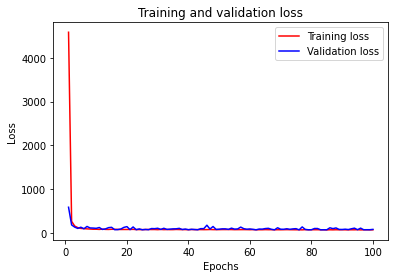

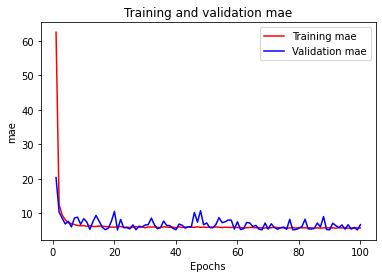

In [ ]:
graphs(best_history)

###Проверка на тестовых данных

In [ ]:
print("[INFO] RUNNING ON TEST DATA: \n")
mse, mae = best_model.evaluate(x_test, y_test, verbose=1)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

27/27 [==============================] - 0s 2ms/step - loss: 112.8958 - mae: 7.1884
[INFO] Mean squared error is 112.8957748413086
[INFO] Mean absolute error is 7.1884260177612305


##Предсказания

###Ручная модель

In [ ]:
predicted_y = model.predict(x_test)
predicted_y = np.reshape(predicted_y, (predicted_y.shape[0]))

###Модель Keras_Tuner

In [ ]:
best_predicted_y = best_model.predict(x_test)
best_predicted_y = np.reshape(best_predicted_y, (best_predicted_y.shape[0]))

###Перевод в векторы

In [ ]:
predicted_y = np.reshape(predicted_y, (predicted_y.shape[0]))
best_predicted_y = np.reshape(best_predicted_y, (best_predicted_y.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))

###Подсчет коэфицента корреляции ручной модели

In [ ]:
best_cc = np.corrcoef(predicted_y, y_test)
best_cc = best_cc[0][1]
print(f'Correlation Coefficient: {best_cc}')

Correlation Coefficient: 0.6676442335612289


###Подсчет коэфицента корреляции модели Keras_Tuner

In [ ]:
best_cc_tuner = np.corrcoef(best_predicted_y, y_test)
best_cc_tuner = best_cc_tuner[0][1]
print(f'Correlation Coefficient: {best_cc_tuner}')

Correlation Coefficient: 0.6699594487913593


###Подсчет разницы между Keras_Tuner и ручной моделью

In [ ]:
cordiff = abs(best_cc - best_cc_tuner)
if best_cc > best_cc_tuner:
  best = "Handmade"
else:
  best = "Keras"
print("Best NN: " + best + 
"\nDifference: """+str(cordiff))

Best NN: Keras
Difference: 0.002315215230130341
